In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

In [54]:
df = pd.read_csv('california_housing_data.csv')
df.head()

# Info dataset
df.info()

# Statistiche descrittive
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Ho tutti numeri (niente stringhe) non nulli -> niente pulizia

## Outlier

In [55]:
# Calcolo Q1 e Q3
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Mantengo solo i dati senza outlier
df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [56]:
# Info dataset
df_clean.info()

# Statistiche descrittive
df_clean.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 16312 entries, 2 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       16312 non-null  float64
 1   HouseAge     16312 non-null  float64
 2   AveRooms     16312 non-null  float64
 3   AveBedrms    16312 non-null  float64
 4   Population   16312 non-null  float64
 5   AveOccup     16312 non-null  float64
 6   Latitude     16312 non-null  float64
 7   Longitude    16312 non-null  float64
 8   MedHouseVal  16312 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16312.000000,16312.000000,16312.000000,16312.000000,16312.000000,16312.000000,16312.000000,16312.000000,16312.000000
mean,3.657930,29.447155,5.156007,1.047226,1271.783227,2.865163,35.670947,-119.626930,1.927436
std,1.444641,12.194464,1.043588,0.066569,627.384658,0.624931,2.140620,1.995143,0.943917
min,0.536000,1.000000,2.032738,0.866013,5.000000,1.161290,32.540000,-124.350000,0.149990
25%,2.561150,19.000000,4.426033,1.002732,814.000000,2.437060,33.940000,-121.820000,1.185000
50%,3.494650,30.000000,5.142857,1.043733,1160.000000,2.814886,34.290000,-118.610000,1.775000
75%,4.583300,38.000000,5.850487,1.088686,1637.000000,3.245208,37.730000,-118.030000,2.494000
max,8.011300,52.000000,8.452915,1.239521,3132.000000,4.560748,41.950000,-114.570000,4.822000


# MACHINE LEARNING MODEL

## Separazione variabili

In [57]:
# X (features/caratteristiche) -> tutte le colonne che userai per fare la predizione
# y (target) -> la colonna che vuoi predire, cioè il prezzo della casa

X = df_clean.drop(["MedHouseVal", "Population", "AveOccup"], axis=1) # caratteristiche -> prendo tutte le colonne tranne quelle indicate
y = df_clean["MedHouseVal"] # target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Visualizzazione della standardizzazione

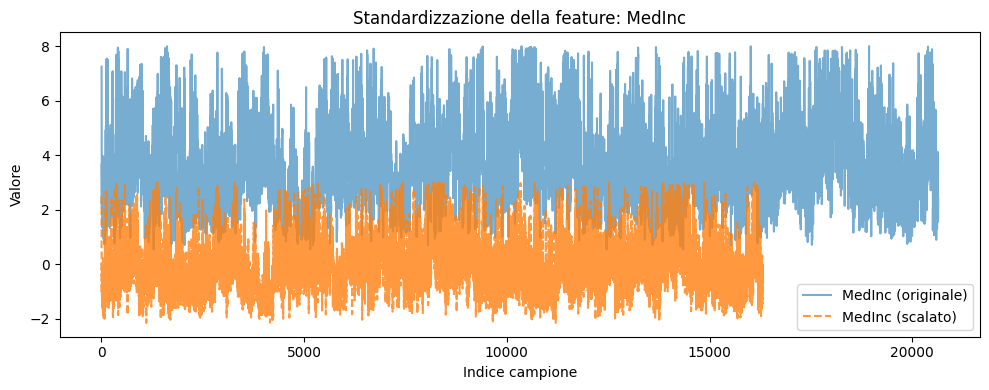

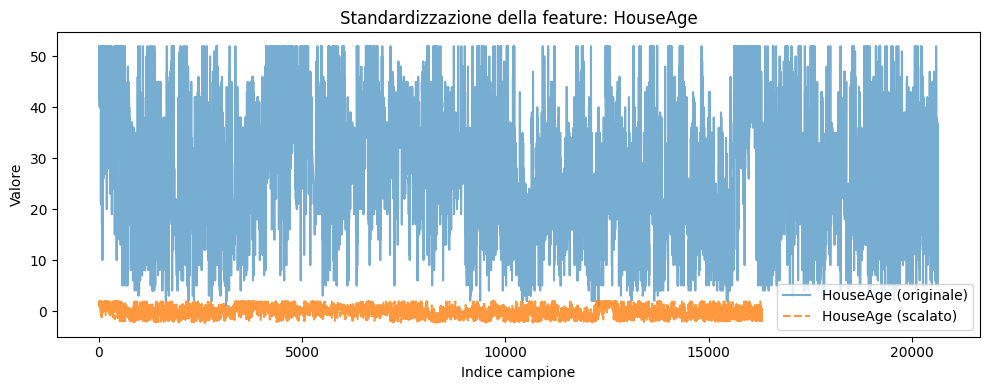

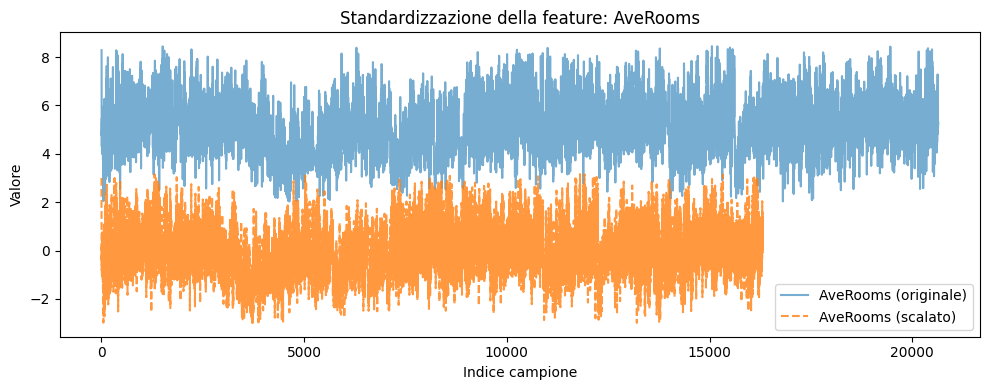

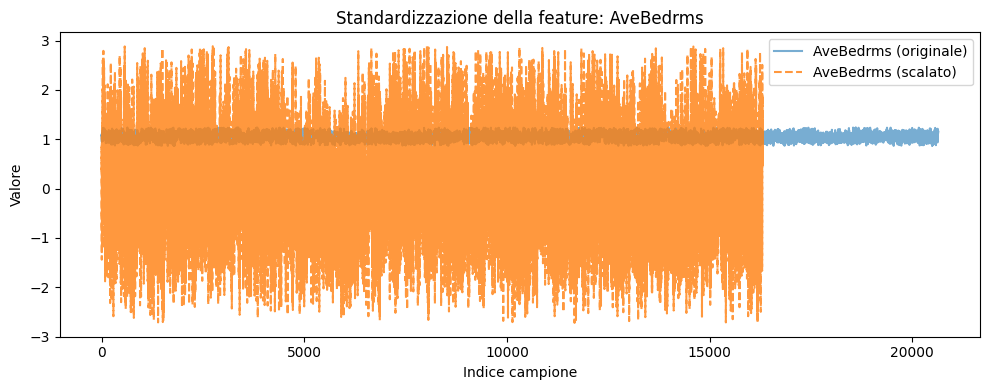

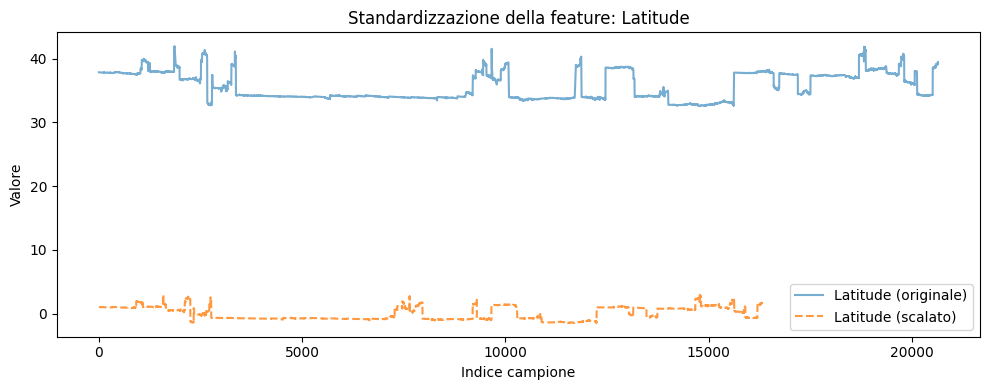

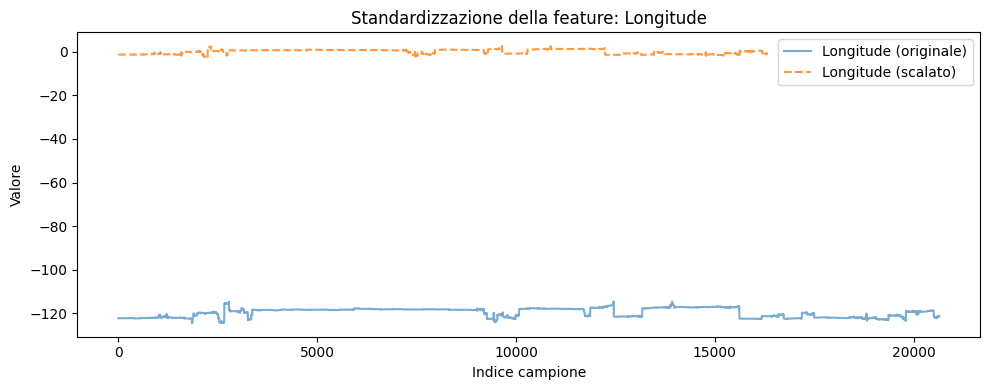

In [58]:
# Converto in DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

for col in X.columns:
    plt.figure(figsize=(10, 4))
    
    plt.plot(X.index, X[col], label=f"{col} (originale)", alpha=0.6)
    plt.plot(X_scaled_df.index, X_scaled_df[col], label=f"{col} (scalato)", linestyle='--', alpha=0.8)
    
    plt.title(f"Standardizzazione della feature: {col}")
    plt.xlabel("Indice campione")
    plt.ylabel("Valore")
    
    plt.legend()
    plt.tight_layout()
    plt.show()

## Funzione di valutazione

Valuta un modello di regressione usando:
- KFold cross-validation se cv è fornito
- Train/Test split se train_test_split_ratio è fornito (es. 0.8)
    
Restituisce un dizionario con:
- MSE_mean
- MSE_std
- RMSE_mean
- RMSE_std
- R2_mean
- R2_std

### Esempio d'uso

Con KFold:
- kf = KFold(n_splits=5, shuffle=True, random_state=42)
- scores = evaluate_model_reg(model, X, y, cv=kf)

Con train/test split 80/20:
- scores_split = evaluate_model_reg(model, X, y, train_test_split_ratio=0.8)

In [59]:
def evaluate_model_reg(model, X_scaled, cv=None, train_test_split_ratio=None, random_state=42):
    scores_mse, scores_rmse, scores_r2 = [], [], []

    # Se X_scaled è fornito, usalo; altrimenti scala dentro la funzione
    if X_scaled is not None:
        X_to_use = X_scaled
        y_to_use = y
    else:
        scaler = StandardScaler()
        X_to_use = scaler.fit_transform(X)
        y_to_use = (y - y.mean()) / y.std()

    if cv is not None:
        
        for train_idx, test_idx in cv.split(X_to_use):
            X_train, X_test = X_to_use[train_idx], X_to_use[test_idx]
            y_train, y_test = y_to_use.iloc[train_idx], y_to_use.iloc[test_idx]


            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            scores_mse.append(mean_squared_error(y_test, y_pred))
            scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
            scores_r2.append(r2_score(y_test, y_pred))

    elif train_test_split_ratio is not None:
        
        train_idx, test_idx = train_test_split(np.arange(len(y_to_use)), train_size=train_test_split_ratio, random_state=random_state)
        
        X_train, X_test = X_to_use[train_idx], X_to_use[test_idx]
        y_train, y_test = y_to_use.iloc[train_idx], y_to_use.iloc[test_idx]


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        scores_mse.append(mean_squared_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        scores_r2.append(r2_score(y_test, y_pred))

    else:
        raise ValueError("Devi fornire cv oppure train_test_split_ratio")

    return {
        "MSE_mean": np.mean(scores_mse),
        "MSE_std": np.std(scores_mse),
        "RMSE_mean": np.mean(scores_rmse),
        "RMSE_std": np.std(scores_rmse),
        "R2_mean": np.mean(scores_r2),
        "R2_std": np.std(scores_r2)
    }


## Definizione CV

In [60]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

## Lista modelli

In [61]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, max_iter=5000, random_state=42),
    "Ridge": Ridge(alpha=1.0, max_iter=5000, random_state=42)
}

## Valutazione modelli lineari

In [62]:
results = []

for name, model in models.items():
    # Train/Test Split
    scores_split = evaluate_model_reg(model, X_scaled, train_test_split_ratio=0.8)
    scores_split["model"] = name
    scores_split["setting"] = "Train/Test Split 80/20"
    results.append(scores_split)

    # KFold
    scores_kf = evaluate_model_reg(model, X_scaled, cv=kf)
    scores_kf["model"] = name
    scores_kf["setting"] = "KFold 3-fold"
    results.append(scores_kf)

## XGBoost con combinazioni iperparametri

In [63]:
xgb_param_grid = [
    {"n_estimators": 50, "max_depth": 3},
    {"n_estimators": 100, "max_depth": 3},
    {"n_estimators": 100, "max_depth": 5},
]

for params in xgb_param_grid:
    model = XGBRegressor(**params, random_state=42, n_jobs=-1, verbosity=0)

    # Train/Test Split
    scores_split = evaluate_model_reg(model, X_scaled, train_test_split_ratio=0.8)
    scores_split["model"] = f"XGBoost (n={params['n_estimators']}, d={params['max_depth']})"
    scores_split["setting"] = "Train/Test Split 80/20"
    results.append(scores_split)

    # KFold
    scores_kf = evaluate_model_reg(model, X_scaled, cv=kf)
    scores_kf["model"] = f"XGBoost (n={params['n_estimators']}, d={params['max_depth']})"
    scores_kf["setting"] = "KFold 3-fold"
    results.append(scores_kf)

# TABELLA RISULTATI

In [64]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="RMSE_mean")
display(df_results.style.hide(axis="index"))

MSE_mean,MSE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,model,setting
0.164705,0.000000,0.405839,0.000000,0.811576,0.000000,"XGBoost (n=100, d=5)",Train/Test Split 80/20
0.183716,0.009668,0.428471,0.011324,0.793863,0.007499,"XGBoost (n=100, d=5)",KFold 3-fold
0.192340,0.000000,0.438566,0.000000,0.779962,0.000000,"XGBoost (n=100, d=3)",Train/Test Split 80/20
0.202660,0.007266,0.450105,0.008046,0.772536,0.004797,"XGBoost (n=100, d=3)",KFold 3-fold
0.217880,0.000000,0.466776,0.000000,0.750744,0.000000,"XGBoost (n=50, d=3)",Train/Test Split 80/20
0.224417,0.010120,0.473607,0.010648,0.748153,0.007537,"XGBoost (n=50, d=3)",KFold 3-fold
0.360503,0.000000,0.600419,0.000000,0.587582,0.000000,Ridge,Train/Test Split 80/20
0.360519,0.000000,0.600432,0.000000,0.587564,0.000000,LinearRegression,Train/Test Split 80/20
0.368156,0.008540,0.606717,0.007062,0.586712,0.002999,Ridge,KFold 3-fold
0.368157,0.008523,0.606718,0.007048,0.586711,0.002982,LinearRegression,KFold 3-fold
